- `conda activate mri`
  - (created in `0_setup.ipynb`)

---

- `jupyter lab` => open this file

---

- Selected Jupyter kernel (`ms_classification`)
  - (created in `0_setup.ipynb`)

---

---

# Imports

---

In [1]:
import seaborn as sns

sns.set_theme(
    context='paper',
    style='whitegrid',
    font_scale=1.2,
    rc={
        'figure.dpi': 300,
        'savefig.dpi': 600,
        'font.family': 'sans-serif',
        'font.sans-serif': ['DejaVu Sans']
    }
)
sns.set_palette('colorblind')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

---

---

# Read File

---

In [2]:
runs = pd.read_csv(   'conformal_measures__runs__marginal.csv')
# summary = pd.read_csv('conformal_measures__summary__marginal.csv')

# runs_by_class = pd.read_csv(   'conformal_measures__runs__marginal__by_class.csv')
# summary_by_class = pd.read_csv('conformal_measures__summary__marginal__by_class.csv')

# runs_cc = pd.read_csv(   'conformal_measures__runs__class_conditional.csv')
# summary_cc = pd.read_csv('conformal_measures__summary__class_conditional.csv')

# runs_cc_by_class = pd.read_csv(   'conformal_measures__runs__class_conditional__by_class.csv')
# summary_cc_by_class = pd.read_csv('conformal_measures__summary__class_conditional__by_class.csv')

---

---

# Prediction Set Size & Coverage Across Field Strengths and Data Variants

---

Only look at valid `cal_test` configurations

---

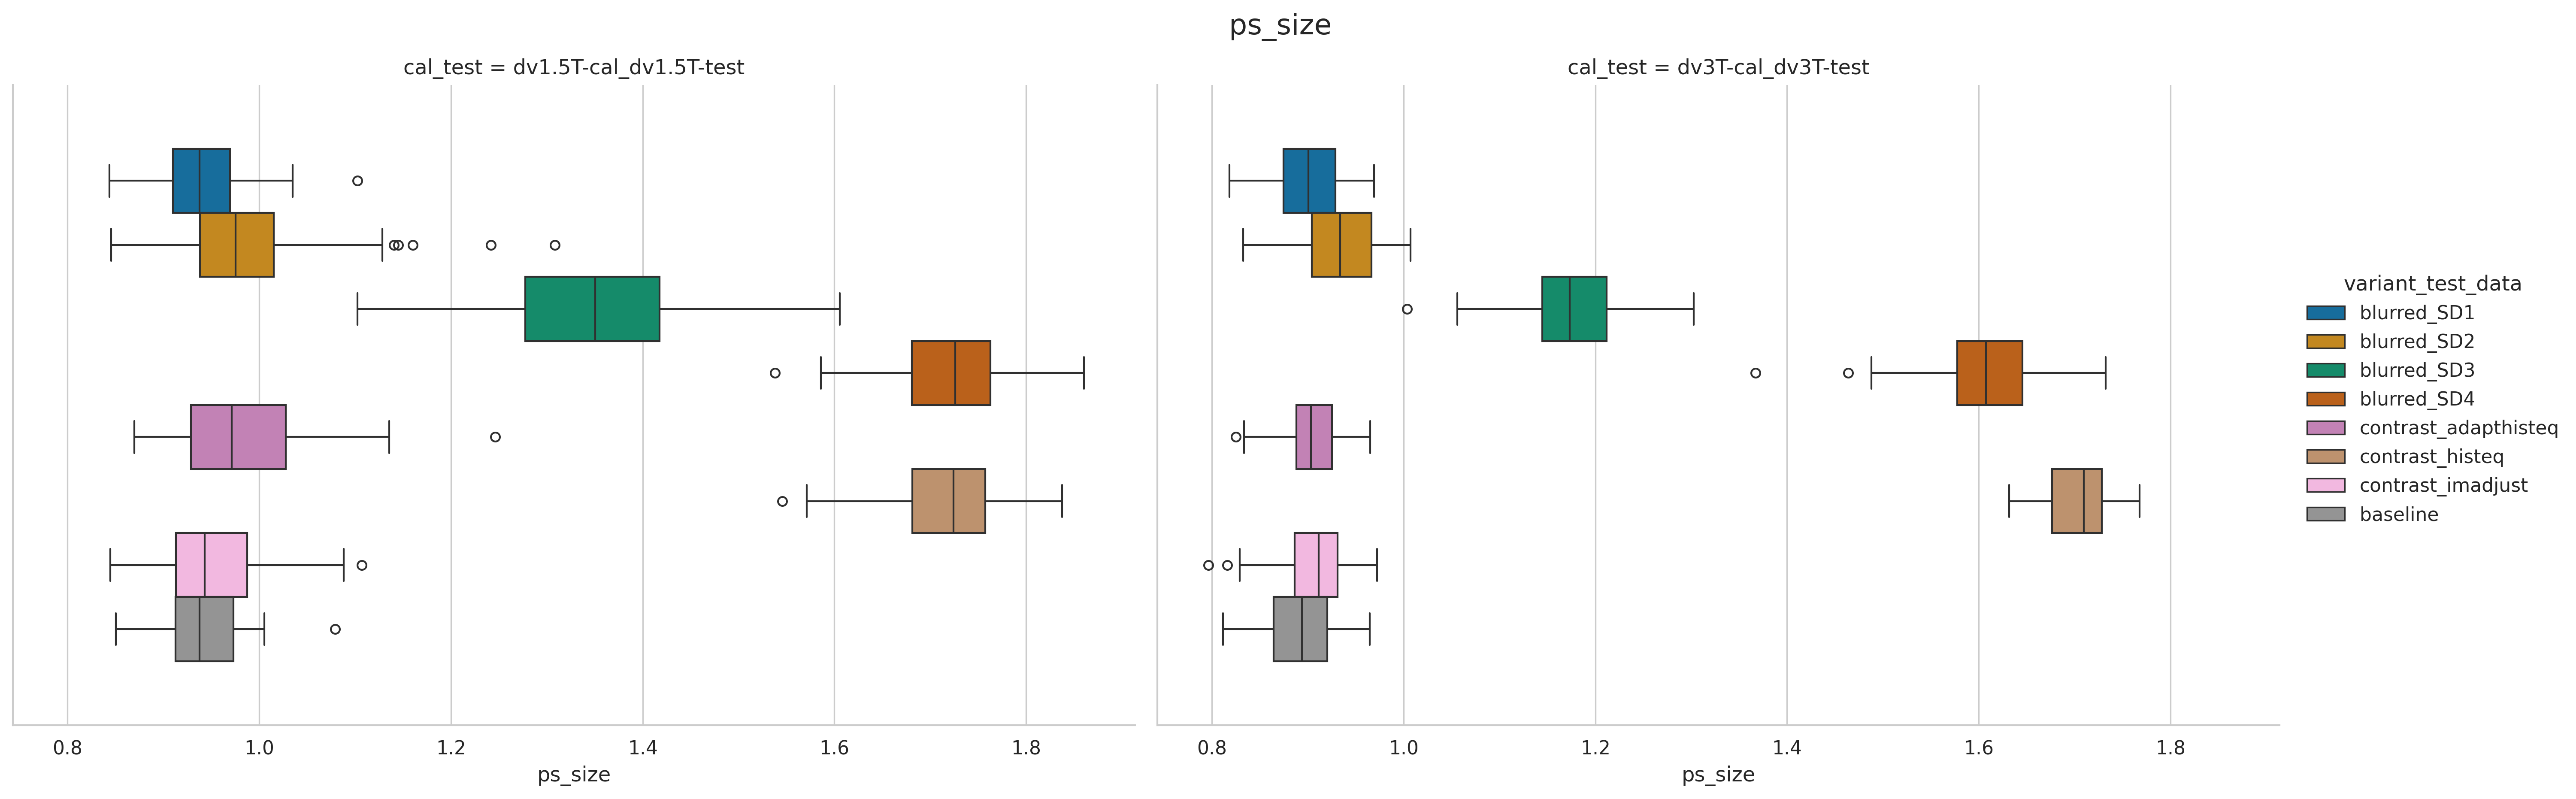

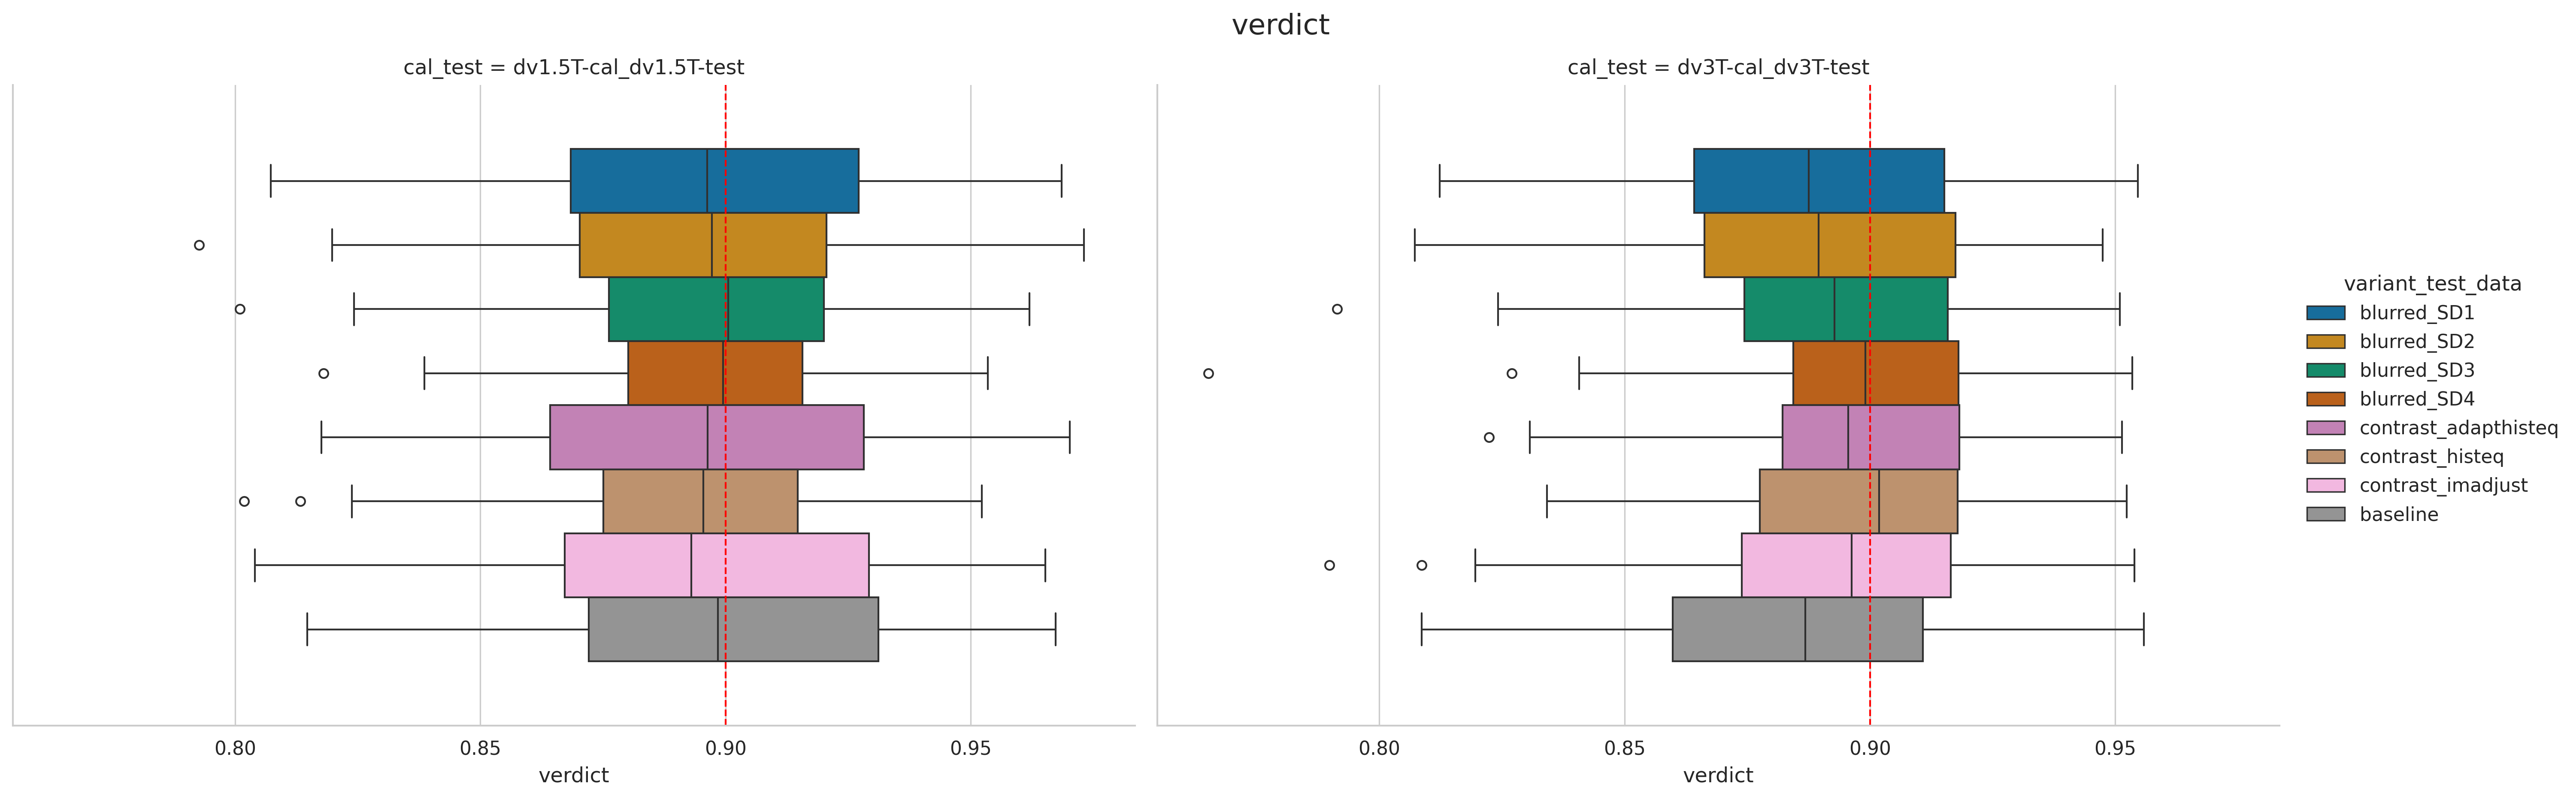

In [3]:
r = runs[~runs.cal_test.str.startswith('base')]
g = sns.catplot(data=r, col='cal_test', x='ps_size', hue='variant_test_data', kind='box', height=6, aspect=1.5)
g.fig.suptitle("ps_size", y=1.03, fontsize='16')
g = sns.catplot(data=r, col='cal_test', x='verdict', hue='variant_test_data', kind='box', height=6, aspect=1.5)
g.fig.suptitle("verdict", y=1.03, fontsize='16')
for ax in g.axes.flatten():
    ax.axvline(0.9, color='red', linestyle='--', linewidth=1)

---

---

## Publication Quality Plot

---

Create figure that focuses on most apparent increasing blur trend as all nominally meet specified coverage

---

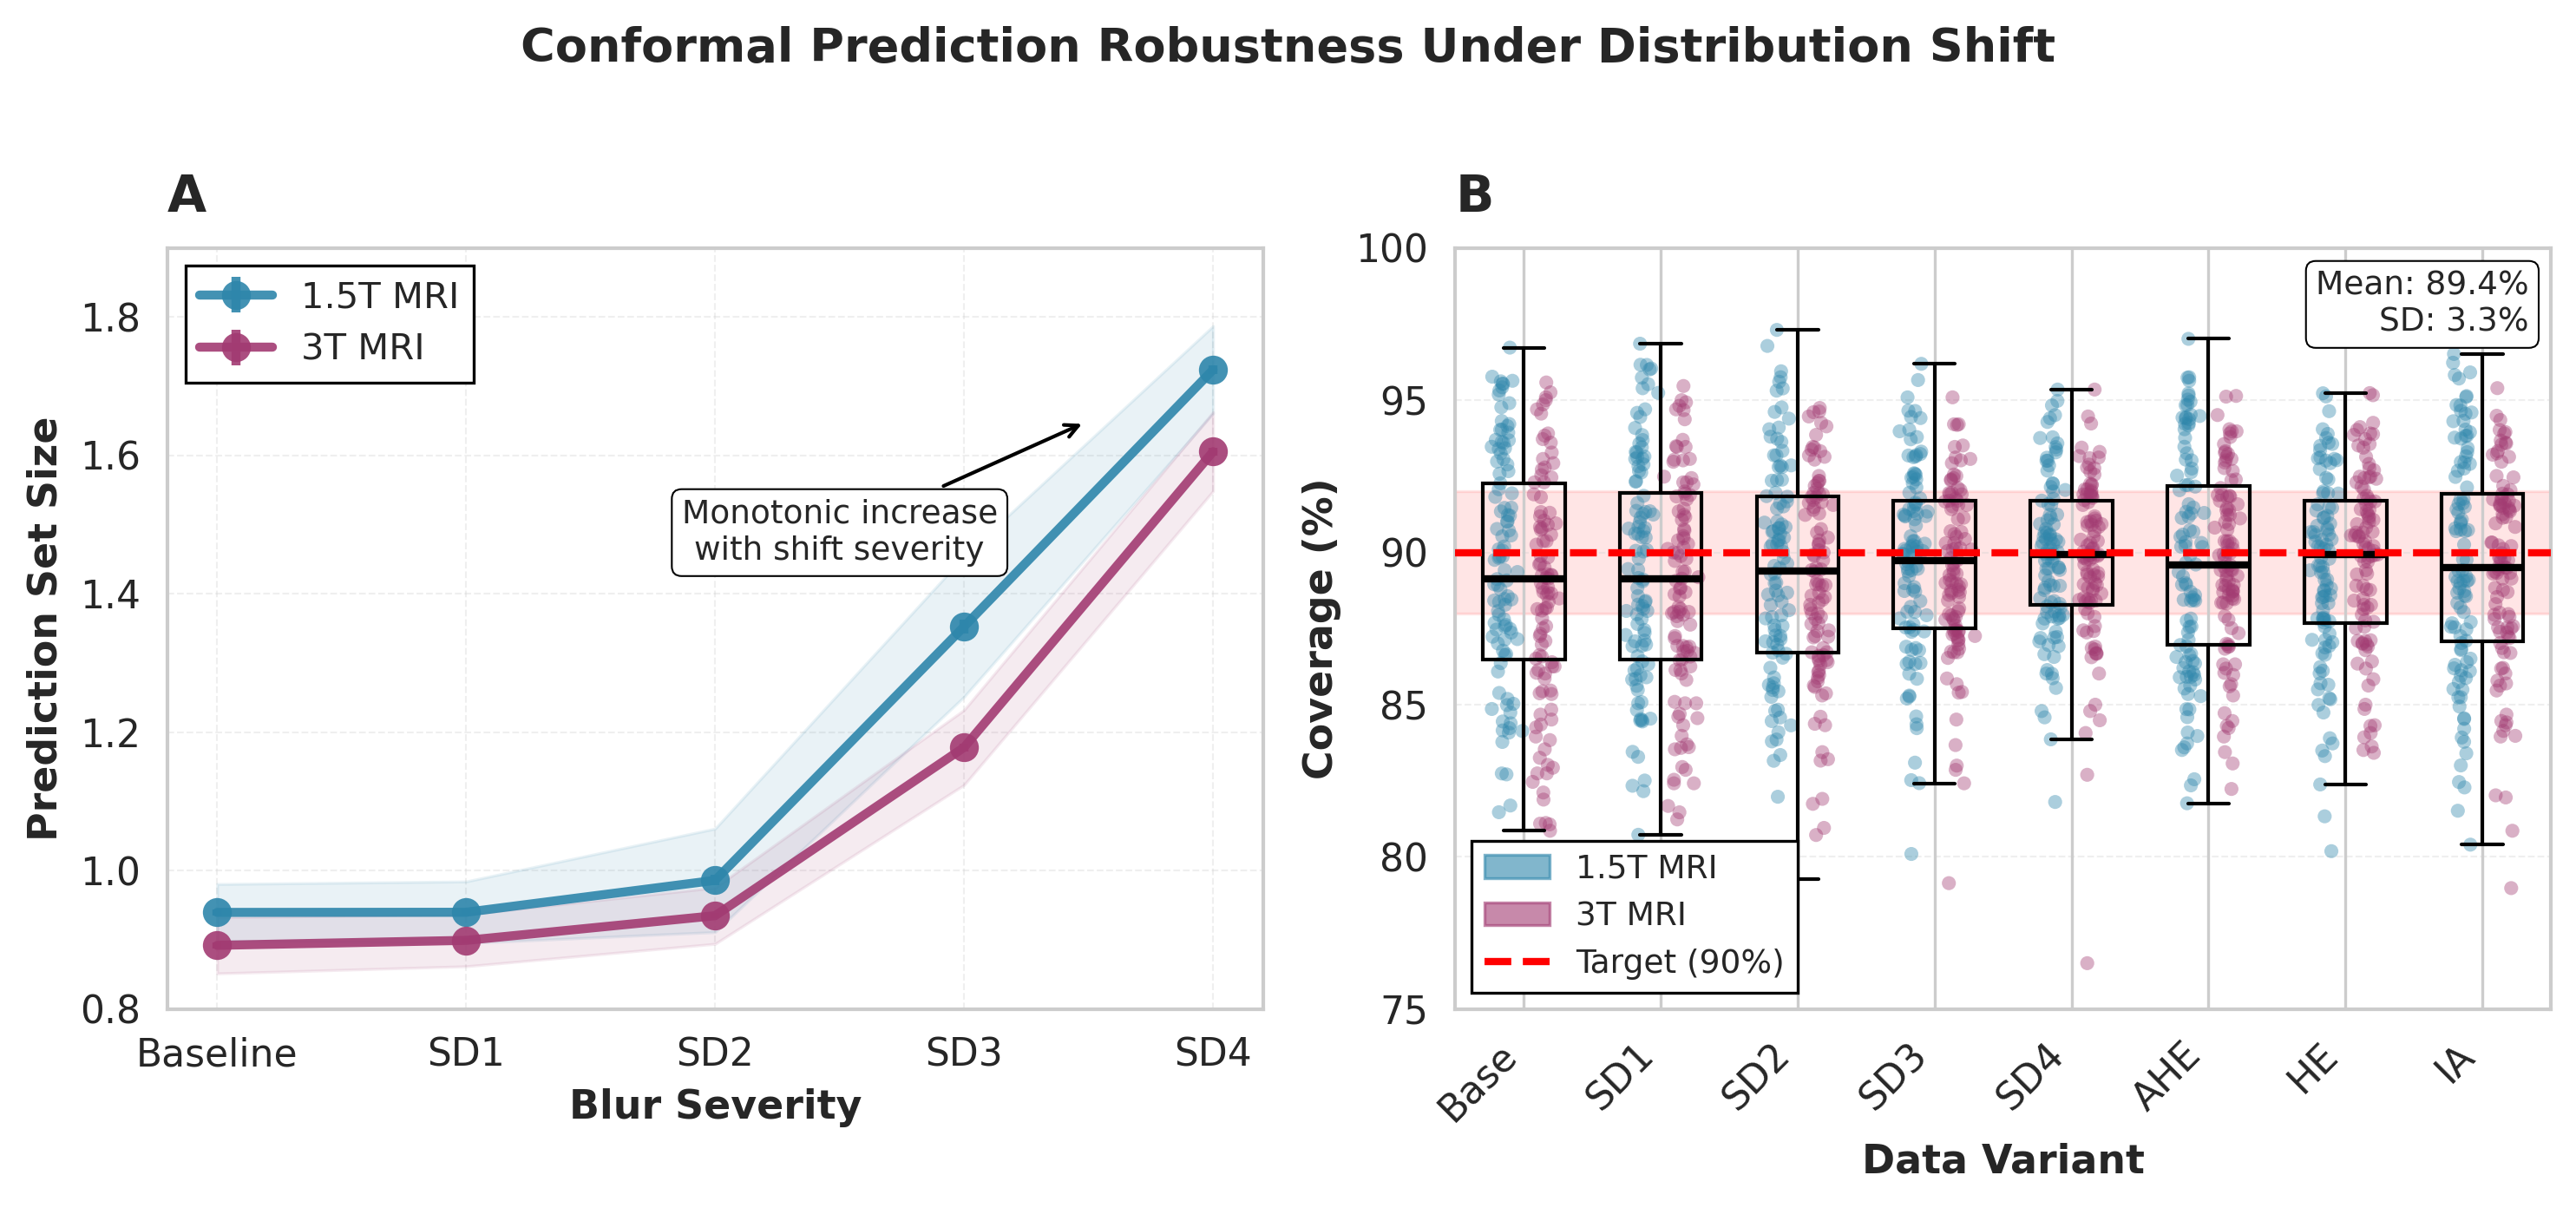


Panel A - Prediction Set Size Increase (Baseline to SD4):
1.5T: 0.940 → 1.724 (83.4% increase)
3T: 0.892 → 1.606 (79.9% increase)

Panel B - Coverage Statistics Across All Variants:
1.5T: 89.6% ± 3.5%
  Runs within ±2% of target: 40.1%
3T: 89.3% ± 3.2%
  Runs within ±2% of target: 47.6%


In [4]:
# Set publication-quality defaults
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['xtick.major.width'] = 1.0
plt.rcParams['ytick.major.width'] = 1.0
plt.rcParams['xtick.major.size'] = 4
plt.rcParams['ytick.major.size'] = 4

# filter out mismatched calibration/test experiment data
r = runs[~runs.cal_test.str.startswith('base')]

# create figure with specific dimensions
fig = plt.figure(figsize=(10, 4.5))

# color palette - professional and colorblind-friendly
colors = {
    '1.5T': '#2E86AB',  # Steel blue
    '3T': '#A23B72',    # Wine purple
}

# ========== PANEL A: Dose-Response Line Graph ==========
ax1 = plt.subplot(1, 2, 1)

# Prepare data for blur progression
blur_variants = ['baseline', 'blurred_SD1', 'blurred_SD2', 'blurred_SD3', 'blurred_SD4']
blur_labels = ['Baseline', 'SD1', 'SD2', 'SD3', 'SD4']

for tesla_type, color in colors.items():
    # extract appropriate calibration test data
    if tesla_type == '1.5T':
        tesla_data = r[r['cal_test'] == 'dv1.5T-cal_dv1.5T-test']
    else:  # 3T
        tesla_data = r[r['cal_test'] == 'dv3T-cal_dv3T-test']
    
    means = []
    stds = []
    sems = []
    
    for variant in blur_variants:
        variant_data = tesla_data[tesla_data['variant_test_data'] == variant]['ps_size']
        means.append(variant_data.mean())
        stds.append(variant_data.std())
        sems.append(variant_data.sem())
    
    x_positions = np.arange(len(blur_variants))
    
    # plot line
    ax1.errorbar(x_positions, means, yerr=sems, 
                 label=f'{tesla_type} MRI', color=color, 
                 marker='o', markersize=8, linewidth=2.5, 
                 capsize=4, capthick=1.5, markeredgewidth=0,
                 alpha=0.9)
    
    # shaded area for standard deviation
    ax1.fill_between(x_positions, 
                     np.array(means) - np.array(stds), 
                     np.array(means) + np.array(stds), 
                     color=color, alpha=0.1)

# formatting for Panel A
ax1.set_xlabel('Blur Severity', fontweight='bold', fontsize=11)
ax1.set_ylabel('Prediction Set Size', fontweight='bold', fontsize=11)
ax1.set_xticks(range(len(blur_labels)))
ax1.set_xticklabels(blur_labels)
ax1.set_ylim([0.8, 1.9])
ax1.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
ax1.legend(frameon=True, fancybox=False, shadow=False, 
           edgecolor='black', framealpha=1, loc='upper left',
           fontsize=10)
ax1.set_title('A', fontweight='bold', fontsize=14, loc='left', pad=10)

# annotation for trend
ax1.annotate('Monotonic increase\nwith shift severity', 
             xy=(3.5, 1.65), xytext=(2.5, 1.45),
             arrowprops=dict(arrowstyle='->', color='black', lw=1),
             fontsize=9, ha='center',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                      edgecolor='black', linewidth=0.5))

# ========== PANEL B: Coverage Stability Strip Plot ==========
ax2 = plt.subplot(1, 2, 2)

# data for all variants
all_variants = ['baseline', 'blurred_SD1', 'blurred_SD2', 'blurred_SD3', 
                'blurred_SD4', 'contrast_adapthisteq', 'contrast_histeq', 
                'contrast_imadjust']
variant_labels = ['Base', 'SD1', 'SD2', 'SD3', 'SD4', 'AHE', 'HE', 'IA']

# combine both Tesla strengths for coverage plot
combined_data = []
for tesla_type in ['dv1.5T-cal_dv1.5T-test', 'dv3T-cal_dv3T-test']:
    tesla_data = r[r['cal_test'] == tesla_type]
    for i, variant in enumerate(all_variants):
        variant_data = tesla_data[tesla_data['variant_test_data'] == variant]['verdict']
        for val in variant_data:
            combined_data.append({
                'variant': variant_labels[i],
                'coverage': val * 100,  # Convert to percentage
                'tesla': '1.5T' if '1.5T' in tesla_type else '3T',
                'variant_full': variant
            })

coverage_df = pd.DataFrame(combined_data)

# create strip plot with overlaid box plot
positions = np.arange(len(variant_labels))

# first, create box plots for summary statistics
bp_data = [coverage_df[coverage_df['variant'] == label]['coverage'].values 
           for label in variant_labels]

bp = ax2.boxplot(bp_data, positions=positions, widths=0.6,
                  patch_artist=True, showfliers=False,
                  boxprops=dict(facecolor='none', edgecolor='black', linewidth=1),
                  whiskerprops=dict(linewidth=1, color='black'),
                  capprops=dict(linewidth=1, color='black'),
                  medianprops=dict(linewidth=2, color='black'))

# add strip plot (jittered points) on top
for i, variant_label in enumerate(variant_labels):
    variant_full = all_variants[i]
    data_1_5t = coverage_df[(coverage_df['variant'] == variant_label) & 
                             (coverage_df['tesla'] == '1.5T')]['coverage']
    data_3t = coverage_df[(coverage_df['variant'] == variant_label) & 
                          (coverage_df['tesla'] == '3T')]['coverage']
    
    # add x-axis jittered points
    if len(data_1_5t) > 0:
        x_1_5t = np.random.normal(i - 0.15, 0.04, size=len(data_1_5t))
        ax2.scatter(x_1_5t, data_1_5t, alpha=0.4, s=15, 
                   color=colors['1.5T'], edgecolors='none')
    
    if len(data_3t) > 0:
        x_3t = np.random.normal(i + 0.15, 0.04, size=len(data_3t))
        ax2.scatter(x_3t, data_3t, alpha=0.4, s=15, 
                   color=colors['3T'], edgecolors='none')

# target coverage line
ax2.axhline(y=90, color='red', linestyle='--', linewidth=2, 
            label='Target Coverage (90%)', zorder=5)

# shaded region for acceptable coverage range (±2% from target)
ax2.axhspan(88, 92, alpha=0.1, color='red', zorder=0)

# formatting for Panel B
ax2.set_xlabel('Data Variant', fontweight='bold', fontsize=11)
ax2.set_ylabel('Coverage (%)', fontweight='bold', fontsize=11)
ax2.set_xticks(positions)
ax2.set_xticklabels(variant_labels, rotation=45, ha='right')
ax2.set_ylim([75, 100])
ax2.grid(True, alpha=0.3, linestyle='--', linewidth=0.5, axis='y')
ax2.set_title('B', fontweight='bold', fontsize=14, loc='left', pad=10)

# legend for Panel B
legend_elements = [
    mpatches.Patch(color=colors['1.5T'], label='1.5T MRI', alpha=0.6),
    mpatches.Patch(color=colors['3T'], label='3T MRI', alpha=0.6),
    plt.Line2D([0], [0], color='red', linestyle='--', linewidth=2, 
               label='Target (90%)')
]
ax2.legend(handles=legend_elements, loc='lower left', 
           frameon=True, fancybox=False, shadow=False,
           edgecolor='black', framealpha=1, fontsize=9)

# statistical annotation
mean_coverage = coverage_df['coverage'].mean()
std_coverage = coverage_df['coverage'].std()
ax2.text(0.98, 0.97, f'Mean: {mean_coverage:.1f}%\nSD: {std_coverage:.1f}%',
         transform=ax2.transAxes, fontsize=9,
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                  edgecolor='black', linewidth=0.5))

# final adjustments
plt.suptitle('Conformal Prediction Robustness Under Distribution Shift', 
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
fig.patch.set_facecolor('white')
plt.savefig('9-4-3__assess_coverage_guarantee_results__impact_of_distribution_shift_on_prediction_set_size.png', 
            dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
plt.show()

print("\nPanel A - Prediction Set Size Increase (Baseline to SD4):")
for tesla_type in ['dv1.5T-cal_dv1.5T-test', 'dv3T-cal_dv3T-test']:
    tesla_label = '1.5T' if '1.5T' in tesla_type else '3T'
    tesla_data = r[r['cal_test'] == tesla_type]
    baseline = tesla_data[tesla_data['variant_test_data'] == 'baseline']['ps_size'].mean()
    sd4 = tesla_data[tesla_data['variant_test_data'] == 'blurred_SD4']['ps_size'].mean()
    increase = ((sd4 - baseline) / baseline) * 100
    print(f"{tesla_label}: {baseline:.3f} → {sd4:.3f} ({increase:.1f}% increase)")

print("\nPanel B - Coverage Statistics Across All Variants:")
for tesla_type in ['1.5T', '3T']:
    tesla_coverage = coverage_df[coverage_df['tesla'] == tesla_type]['coverage']
    print(f"{tesla_type}: {tesla_coverage.mean():.1f}% ± {tesla_coverage.std():.1f}%")
    within_2pct = np.sum((tesla_coverage >= 88) & (tesla_coverage <= 92)) / len(tesla_coverage) * 100
    print(f"  Runs within ±2% of target: {within_2pct:.1f}%")

---

---

---

---

Stats for first set of boxplots

In [5]:
def compute_boxplot_stats(data, groupby_cols, value_col):
    """
    Compute boxplot statistics for grouped data
    """
    def box_stats(x):
        if len(x) == 0:
            return pd.Series({
                'count': 0,
                'mean': np.nan,
                'std': np.nan,
                'min': np.nan,
                'q25': np.nan,
                'median': np.nan,
                'q75': np.nan,
                'max': np.nan,
                'iqr': np.nan
            })
        
        return pd.Series({
            'count': len(x),
            'mean': np.mean(x),
            'std': np.std(x, ddof=1),
            'min': np.min(x),
            'q25': np.percentile(x, 25),
            'median': np.percentile(x, 50),
            'q75': np.percentile(x, 75),
            'max': np.max(x),
            'iqr': np.percentile(x, 75) - np.percentile(x, 25)
        })
    
    return data.groupby(groupby_cols)[value_col].apply(box_stats).unstack()

# Get statistics for ps_size
print("=== PREDICTION SET SIZE STATISTICS ===")
ps_size_stats = compute_boxplot_stats(r, ['cal_test', 'variant_test_data'], 'ps_size')
print(ps_size_stats.round(4))

print("\n=== VERDICT/COVERAGE STATISTICS ===")
# Get statistics for verdict (coverage)
verdict_stats = compute_boxplot_stats(r, ['cal_test', 'variant_test_data'], 'verdict')
print(verdict_stats.round(4))

# Additional analysis: Coverage close to target (0.9)
print("\n=== COVERAGE ANALYSIS (Target = 0.9) ===")
coverage_analysis = r.groupby(['cal_test', 'variant_test_data'])['verdict'].agg([
    ('mean_coverage', 'mean'),
    ('std_coverage', 'std'),
    ('deviation_from_target', lambda x: np.mean(x) - 0.9),
    ('abs_deviation_from_target', lambda x: np.abs(np.mean(x) - 0.9)),
    ('pct_above_target', lambda x: np.mean(x > 0.9) * 100),
    ('pct_below_target', lambda x: np.mean(x < 0.9) * 100)
]).round(4)
print(coverage_analysis)

# Outlier detection for ps_size
print("\n=== PREDICTION SET SIZE OUTLIERS ===")
def detect_outliers(group):
    q1, q3 = np.percentile(group, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = group[(group < lower_bound) | (group > upper_bound)]
    return pd.Series({
        'n_outliers': len(outliers),
        'outlier_pct': len(outliers) / len(group) * 100 if len(group) > 0 else 0,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    })

ps_outliers = r.groupby(['cal_test', 'variant_test_data'])['ps_size'].apply(detect_outliers).unstack()
print(ps_outliers.round(4))

# Statistical comparisons between variants
print("\n=== VARIANT COMPARISONS (vs baseline if available) ===")
if 'baseline' in r['variant_test_data'].values:
    for tesla_type in r['cal_test'].unique():
        print(f"\n--- {tesla_type} ---")
        tesla_data = r[r['cal_test'] == tesla_type]
        baseline_ps = tesla_data[tesla_data['variant_test_data'] == 'baseline']['ps_size']
        baseline_coverage = tesla_data[tesla_data['variant_test_data'] == 'baseline']['verdict']
        
        for variant in tesla_data['variant_test_data'].unique():
            if variant != 'baseline':
                var_ps = tesla_data[tesla_data['variant_test_data'] == variant]['ps_size']
                var_coverage = tesla_data[tesla_data['variant_test_data'] == variant]['verdict']
                
                if len(baseline_ps) > 0 and len(var_ps) > 0:
                    ps_diff = np.mean(var_ps) - np.mean(baseline_ps)
                    coverage_diff = np.mean(var_coverage) - np.mean(baseline_coverage)
                    
                    print(f"{variant}:")
                    print(f"  PS Size diff from baseline: {ps_diff:.4f}")
                    print(f"  Coverage diff from baseline: {coverage_diff:.4f}")

=== PREDICTION SET SIZE STATISTICS ===
                                             count    mean     std     min  \
cal_test               variant_test_data                                     
dv1.5T-cal_dv1.5T-test baseline              100.0  0.9399  0.0410  0.8507   
                       blurred_SD1           100.0  0.9401  0.0445  0.8438   
                       blurred_SD2           100.0  0.9862  0.0748  0.8458   
                       blurred_SD3           100.0  1.3529  0.1014  1.1027   
                       blurred_SD4           100.0  1.7240  0.0630  1.5379   
                       contrast_adapthisteq  100.0  0.9845  0.0707  0.8695   
                       contrast_histeq       100.0  1.7179  0.0619  1.5455   
                       contrast_imadjust     100.0  0.9513  0.0522  0.8448   
dv3T-cal_dv3T-test     baseline              100.0  0.8923  0.0406  0.8116   
                       blurred_SD1           100.0  0.8995  0.0375  0.8181   
                       bl

---

---

---

## Class-Conditional CP Follows Similar Trend 

Like above, we tend to see prediction set size increase with blur severity. Additionally, nominal coverage is maintained. Coverage variance increased notably for the minority class due to limited calibration samples, matching theoretical Beta-binomial predictions from preceding noteboook.

---

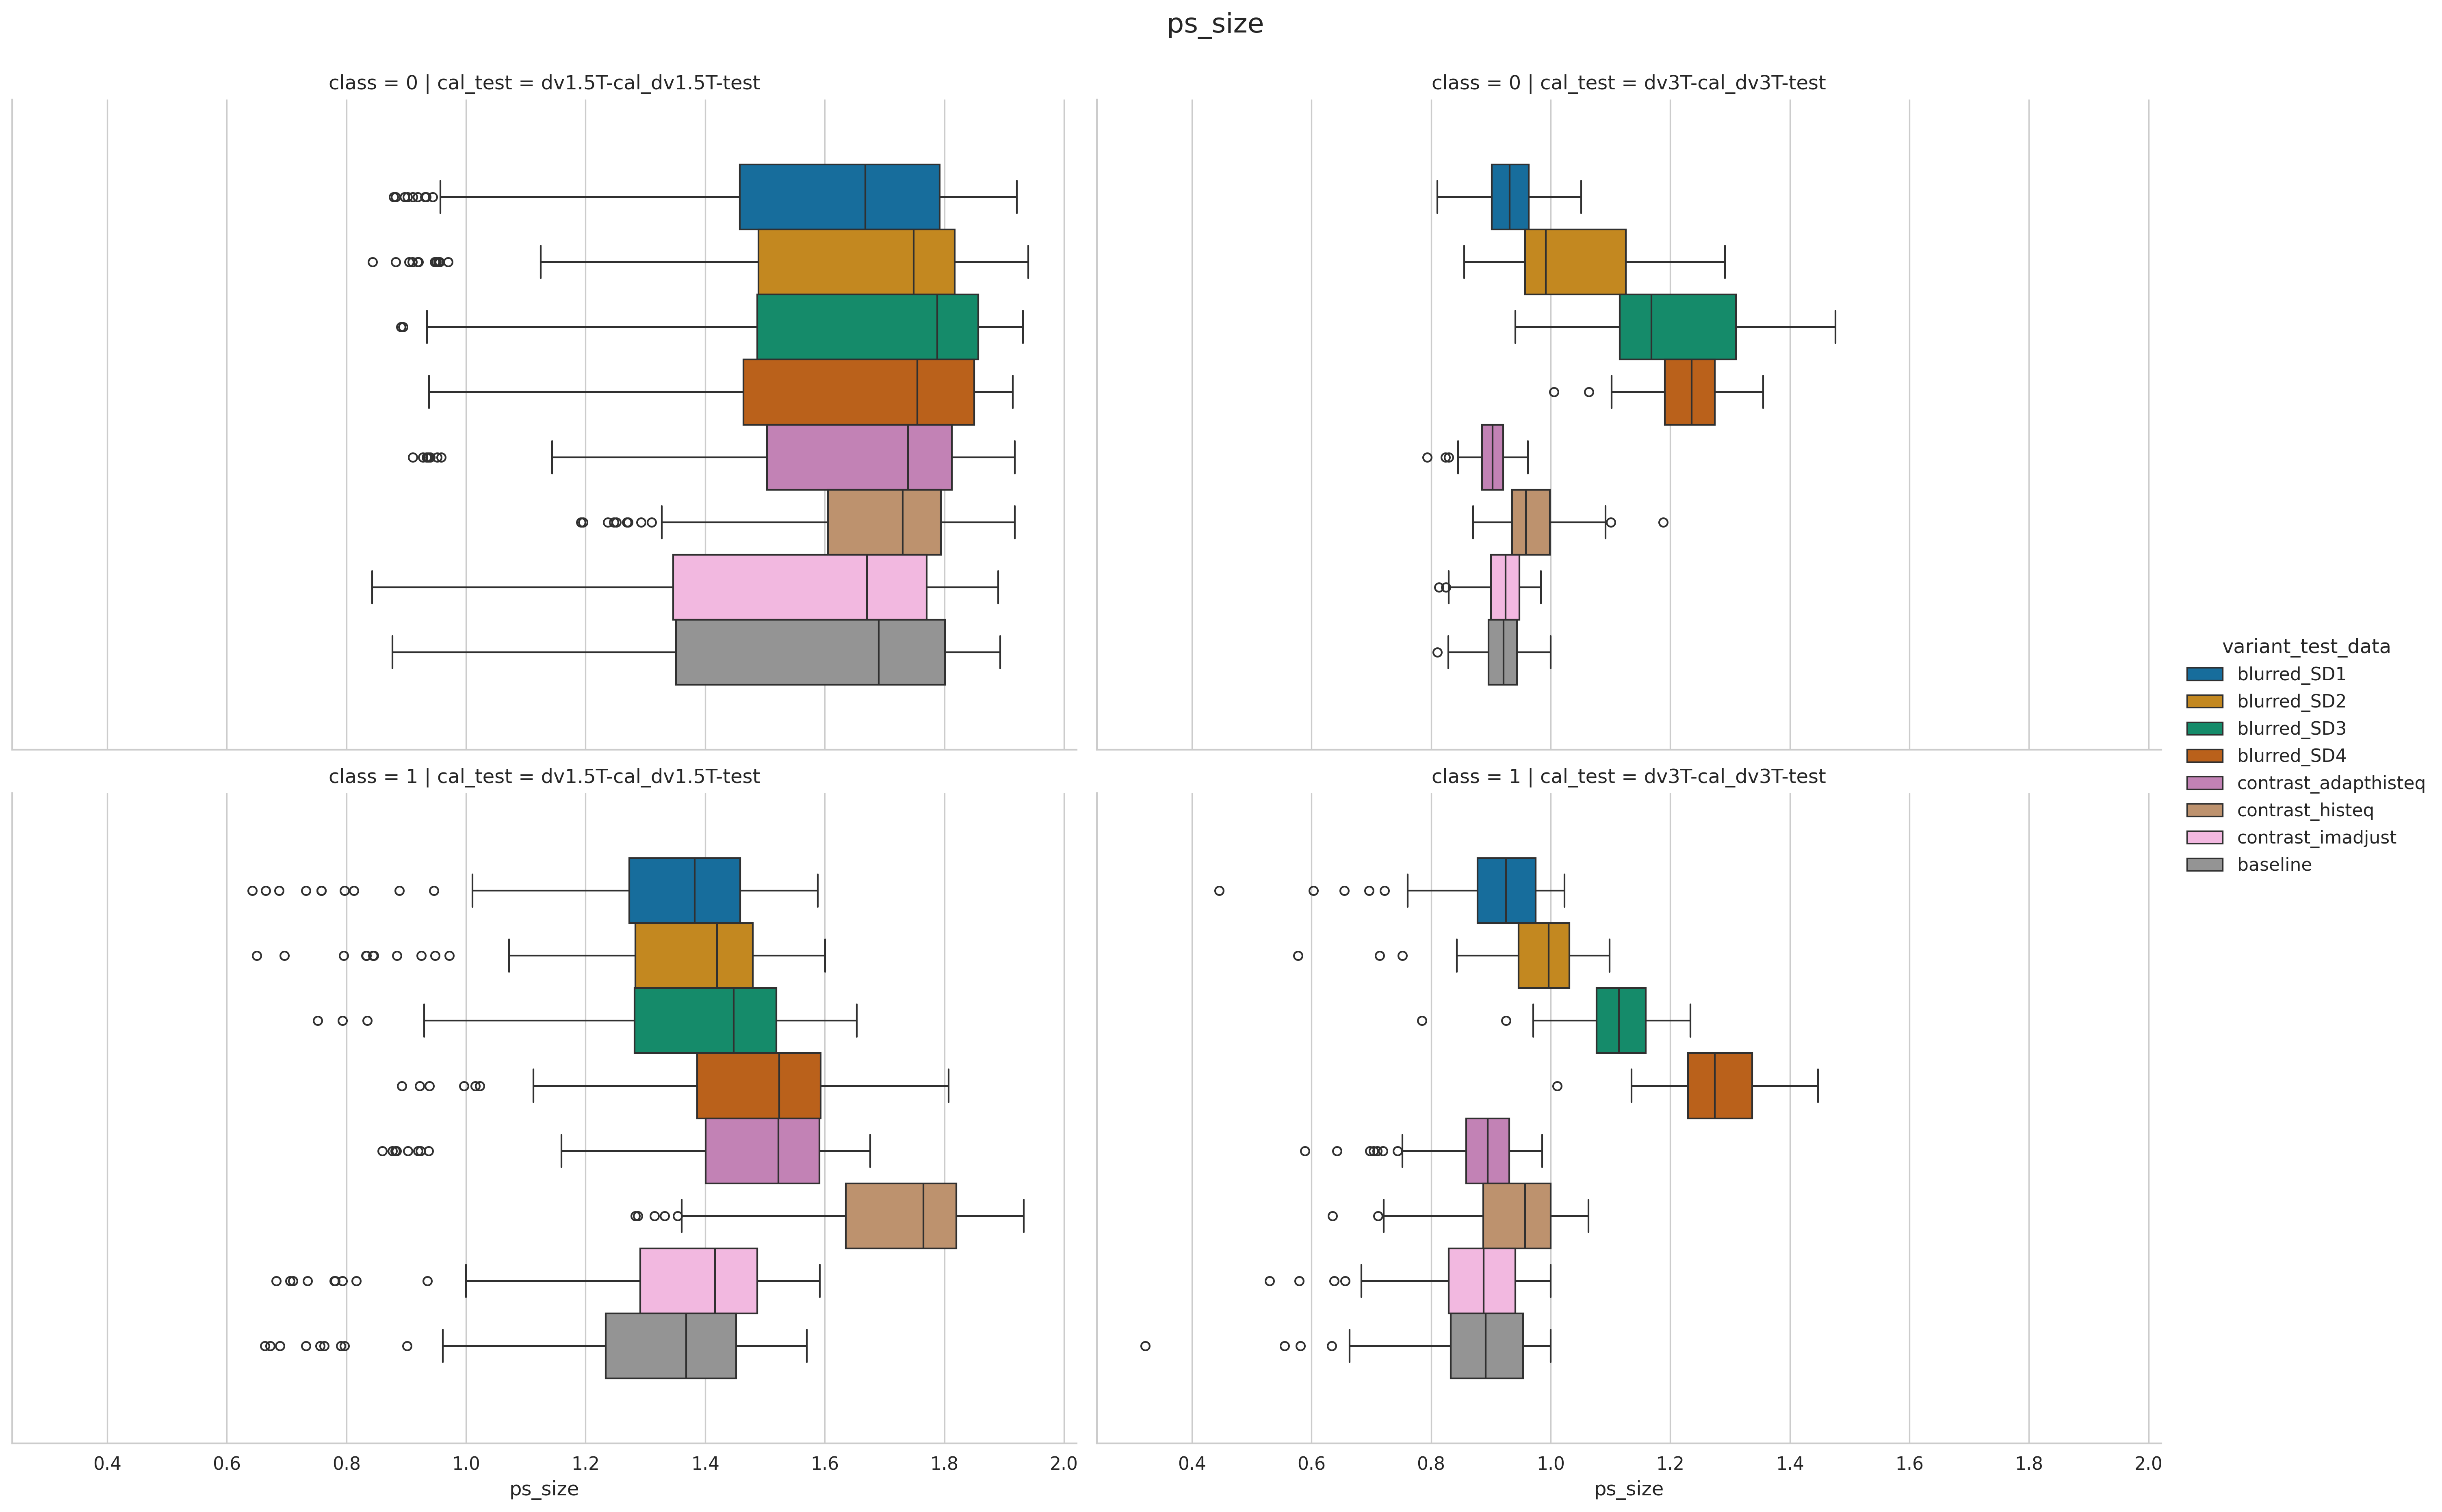

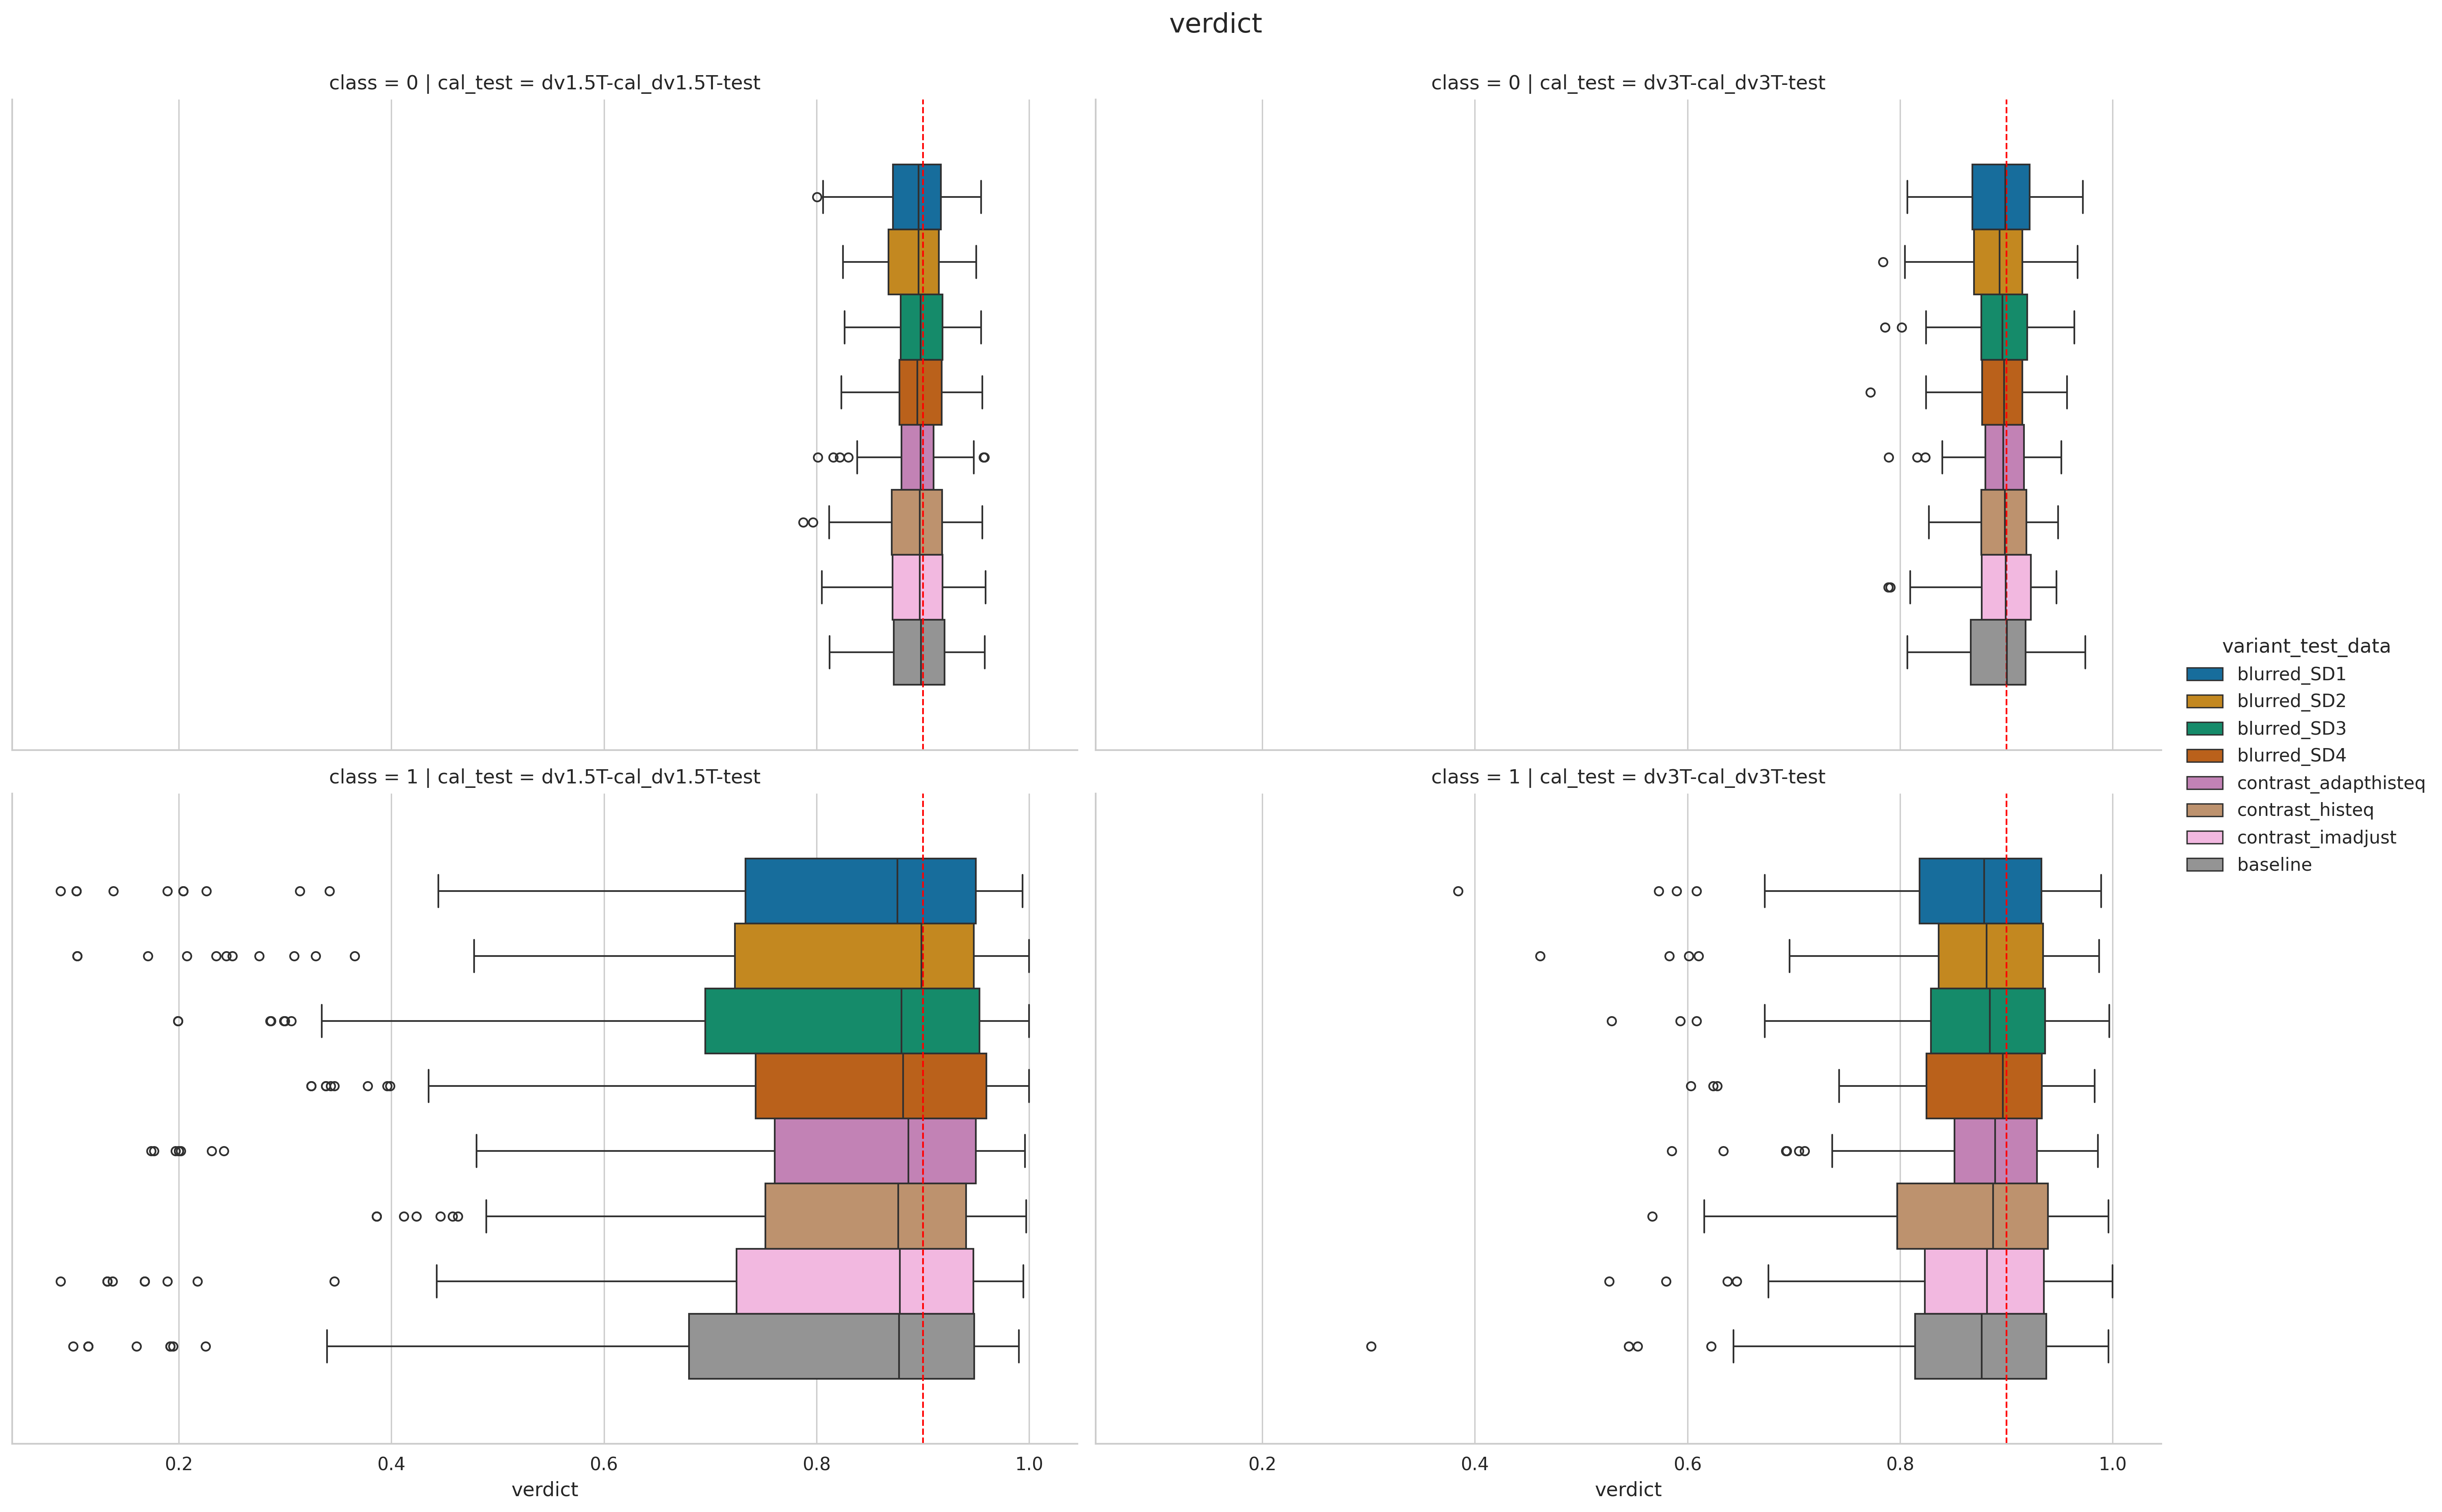

In [8]:
runs_cc_bc = pd.read_csv(   'conformal_measures__runs__class_conditional__by_class.csv')
r = runs_cc_bc[~runs_cc_bc.cal_test.str.startswith('base')]
g = sns.catplot(data=r, col='cal_test', x='ps_size', hue='variant_test_data', kind='box', height=6, aspect=1.5, row='class')
g.fig.suptitle("ps_size", y=1.03, fontsize='16')
g = sns.catplot(data=r, col='cal_test', x='verdict', hue='variant_test_data', kind='box', height=6, aspect=1.5, row='class')
g.fig.suptitle("verdict", y=1.03, fontsize='16')
for ax in g.axes.flatten():
    ax.axvline(0.9, color='red', linestyle='--', linewidth=1)

---

---

---

---

---